### Эмбеддинги в NLP

В этом задании мы научимся работать с моделями для построения векторных представлений текста. Загрузим и потестируем предобученные модели, посмотрим, какие свойства и функции у них есть, обучим свою модель и с помощью нее улучшим качество кластеризации(и/или классификации) текстов.

Перед тем как приступать к выполнению задания не забудьте выполнить команду pip install -r <path_to_rep_requirements.txt> для того, чтобы в вашем виртуальном окружении были установлены правильные версии python пакетов.

In [1]:
import string
import warnings
import logging
import itertools

import nltk
import gensim
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import Word2Vec
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import MiniBatchKMeans

D:\programming\Anaconda1\envs\dmia_dl\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
%pylab inline

plt.style.use('default')
figsize(12, 9)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
 
font = {'family': 'Verdana',
        'weight': 'normal'}
mpl.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


Скачиваем rucorpora 15 с [диска](https://yadi.sk/d/fLRMFhm03Pbs98).
Либо выбираем предобученную модель с https://rusvectores.org/ru/models/. Выбор нужно обосновать.

In [4]:
path_to_ruscorpora = 'ruscorpora.model.bin'

#### Загрузим обученную на ruscorpora модель word2vec

In [5]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_ruscorpora,
    binary=True
)
model_word2vec.wv.vocab

2019-04-15 23:38:30,821 : INFO : loading projection weights from ruscorpora.model.bin
2019-04-15 23:38:39,305 : INFO : loaded (374526, 300) matrix from ruscorpora.model.bin


{'это': <gensim.models.keyedvectors.Vocab at 0x1ff30782b38>,
 'весь': <gensim.models.keyedvectors.Vocab at 0x1ff307823c8>,
 'человек': <gensim.models.keyedvectors.Vocab at 0x1ff307821d0>,
 'мочь': <gensim.models.keyedvectors.Vocab at 0x1ff30782390>,
 'год': <gensim.models.keyedvectors.Vocab at 0x1ff307825c0>,
 'сказать': <gensim.models.keyedvectors.Vocab at 0x1ff30782748>,
 'время': <gensim.models.keyedvectors.Vocab at 0x1ff30782710>,
 'говорить': <gensim.models.keyedvectors.Vocab at 0x1ff30782780>,
 'становиться': <gensim.models.keyedvectors.Vocab at 0x1ff307827b8>,
 'знать': <gensim.models.keyedvectors.Vocab at 0x1ff30782828>,
 'самый': <gensim.models.keyedvectors.Vocab at 0x1ff30782898>,
 'жизнь': <gensim.models.keyedvectors.Vocab at 0x1ff307827f0>,
 'дело': <gensim.models.keyedvectors.Vocab at 0x1ff30782860>,
 'день': <gensim.models.keyedvectors.Vocab at 0x1ff307828d0>,
 'рука': <gensim.models.keyedvectors.Vocab at 0x1ff345e6208>,
 'первый': <gensim.models.keyedvectors.Vocab at 0x1

#### Посмотрим, как с ней обращаться

Можно посмотреть наиболее похожие на конкретное слово слова. Попробуйте свойства векторов word2vec: и подумайте какие слова нужно послать на вход, чтобы получить на выходе слова "школа",  "машинное", "обучение".

In [6]:
model_word2vec.most_similar(positive=['корабль'],
                            negative=['парус'],
                            topn=3)

2019-04-15 23:38:39,401 : INFO : precomputing L2-norms of word weight vectors


[('судно', 0.4670174717903137),
 ('крейсер', 0.374319463968277),
 ('пароход', 0.33206045627593994)]

In [7]:
model_word2vec.most_similar(positive=['корабль', 'летать'],
                            negative=['плавать'],
                            topn=3)

[('самолет', 0.5802854299545288),
 ('судно', 0.533637523651123),
 ('дирижабль', 0.5083058476448059)]

In [8]:
model_word2vec.most_similar(positive=['шахтер'],
                            negative=['грязь'],
                            topn=3)

[('горняк', 0.3543156683444977),
 ('ударник', 0.336887001991272),
 ('металлург', 0.3220180869102478)]

In [9]:
model_word2vec.most_similar(positive=['учение', 'тьма'],
                            negative=['свет'],
                            topn=3)

[('мрак', 0.4193800687789917),
 ('догмат', 0.38442569971084595),
 ('философия', 0.3840946555137634)]

Еще есть функция, которая выводит лишнее слово в строке. Попробуйте придумать пример, с которым word2vec не справится.

In [10]:
model_word2vec.doesnt_match("коньяк компот водка пиво".split())

'компот'

Функция, которая выводит сходство между словами.  С ее помощью можно понимать значение слова нефть.

In [11]:
print(model_word2vec.similarity('нефть', 'газ'))
print(model_word2vec.similarity('нефть', 'вода'))
print(model_word2vec.similarity('нефть', 'водка'))
print(model_word2vec.similarity('нефть', 'духи'))
print(model_word2vec.similarity('нефть', 'компот'))

0.40178457553503455
0.24677068884613584
0.08598832392459937
0.029723395355918565
0.014373137644951142


Или смотреть, где в России больше нефти.

In [12]:
print(model_word2vec.similarity('нефть', 'чечня'))
print(model_word2vec.similarity('нефть', 'якутск'))
print(model_word2vec.similarity('нефть', 'москва'))
print(model_word2vec.similarity('нефть', 'саратов'))
print(model_word2vec.similarity('нефть', 'сибирь'))

0.10231813580537621
0.03745940751759377
0.007655203112322324
0.004379906037606789
0.08630519115837115


### Пункт 0
Допишите своих интересных примеров, характеризующих word2vec, попробуйте обосновать полученные результаты.

In [13]:
model_word2vec.doesnt_match("вода огонь земля воздух человек".split())

'человек'

In [14]:
model_word2vec.doesnt_match("долматинец овчарка алабай кот".split())
#пример где в2в не справился. Слова достаточно сложные - породы собаки.
#Хотя кажется, что всё-таки породы собак должны употребляться в текстах вместе
#Например во время перечисления. Кот же здесь вообще лишний
#Более того, все три породы - большие собаки. И только долматинец не охранная, по моим данным
#В общем просто сложные слова и зависимости.

'алабай'

In [15]:
print(model_word2vec.similarity('лекция', 'чечня'))
print(model_word2vec.similarity('лекция', 'якутск'))
print(model_word2vec.similarity('лекция', 'москва'))
print(model_word2vec.similarity('лекция', 'саратов'))
print(model_word2vec.similarity('лекция', 'сибирь'))
#Москва просвещенная !
#С чечней отрицательная корреляция. Но не будем об этом.

-0.022857646495660862
0.04001267516916817
0.08202464679694266
0.02817681239099919
0.019709920926973143


In [16]:
model_word2vec.most_similar(positive=['здание', 'образование'],
                            negative=[],
                            topn=3)

[('школа', 0.43927669525146484),
 ('постройка', 0.42381638288497925),
 ('дом', 0.3932963013648987)]

In [17]:
model_word2vec.most_similar(positive=['процесс', 'знание'],
                            negative=[],
                            topn=3)
#почти обучение !

[('познание', 0.6062214970588684),
 ('мышление', 0.5230305194854736),
 ('навык', 0.4822564125061035)]

In [18]:
model_word2vec.most_similar(positive=['учитель', 'знание'],
                            negative=['ученик'],
                            topn=3)

[('познание', 0.5539453029632568),
 ('построяются', 0.4592708349227905),
 ('навык', 0.38919389247894287)]

#### Теперь давайте обучим собственную модель
В качестве обучающего корпуса возьмем новости по 20 темам.

In [19]:
train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names, " - 20 возможных тем")

dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

dataset.data[0].split()

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']  - 20 возможных тем


['From:',
 'erik@cheshire.oxy.edu',
 '(Erik',
 'Adams)',
 'Subject:',
 'HELP!!',
 'My',
 'Macintosh',
 '"luggable"',
 'has',
 'lines',
 'on',
 'its',
 'screen!',
 'Organization:',
 'Occidental',
 'College,',
 'Los',
 'Angeles,',
 'CA',
 '90041',
 'USA.',
 'Distribution:',
 'comp',
 'Lines:',
 '20',
 'Okay,',
 'I',
 "don't",
 'use',
 'it',
 'very',
 'much,',
 'but',
 'I',
 'would',
 'like',
 'for',
 'it',
 'to',
 'keep',
 'working',
 'correctly,',
 'at',
 'least',
 'as',
 'long',
 'as',
 'Apple',
 'continues',
 'to',
 'make',
 'System',
 'software',
 'that',
 'will',
 'run',
 'on',
 'it,',
 'if',
 'slowly',
 ':-)',
 'Here',
 'is',
 'the',
 'problem:',
 'When',
 'the',
 'screen',
 'is',
 'tilted',
 'too',
 'far',
 'back,',
 'vertical',
 'lines',
 'appear',
 'on',
 'the',
 'screen.',
 'They',
 'are',
 'every',
 '10',
 'pixels',
 'or',
 'so,',
 'and',
 'seem',
 'to',
 'be',
 'affected',
 'somewhat',
 'by',
 'opening',
 'windows',
 'and',
 'pulling',
 'down',
 'menus.',
 'It',
 'looks',
 't

### Пункт 1

Предобработаем эти новости. Выкинем цифры, знаки пунктуации, переведем в нижний регистр, разобьем на слова.

Нормализуйте слова, например с помощью модуля nltk (или используйте любой другой способ на ваш выбор).

In [20]:
import re
#for normalization

In [21]:
def normalize(raw_text):
    raw_text = raw_text.lower().replace('\n', ' ') #lowering and remove \n symbols
    preprocessed_text = re.sub(r'\d+', '', raw_text) #removing digits

    
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    preprocessed_text = regex.sub('', preprocessed_text)       #removing punctuation
    
    preprocessed_text = preprocessed_text.strip() #remove whitespaces
    
    #стоит использовать остальные пункты для препроцессинга текста. Как удаление стопслов, слов не имеющих смысла.
    
    return [word for word in preprocessed_text.split(' ') if len(word)]

In [22]:
data_normalized = [normalize(news) for news in tqdm(dataset.data)]

100%|████████████████████████████████████████████████████████████████████████████| 1777/1777 [00:00<00:00, 6170.52it/s]


Теперь обучающий корпус готов.

In [23]:
sentences = data_normalized
model = gensim.models.Word2Vec(sentences, min_count=1)

2019-04-15 23:38:43,529 : INFO : collecting all words and their counts
2019-04-15 23:38:43,531 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-15 23:38:43,628 : INFO : collected 27626 word types from a corpus of 467951 raw words and 1777 sentences
2019-04-15 23:38:43,630 : INFO : Loading a fresh vocabulary
2019-04-15 23:38:43,693 : INFO : min_count=1 retains 27626 unique words (100% of original 27626, drops 0)
2019-04-15 23:38:43,695 : INFO : min_count=1 leaves 467951 word corpus (100% of original 467951, drops 0)
2019-04-15 23:38:43,791 : INFO : deleting the raw counts dictionary of 27626 items
2019-04-15 23:38:43,794 : INFO : sample=0.001 downsamples 46 most-common words
2019-04-15 23:38:43,795 : INFO : downsampling leaves estimated 372402 word corpus (79.6% of prior 467951)
2019-04-15 23:38:43,878 : INFO : estimated required memory for 27626 words and 100 dimensions: 35913800 bytes
2019-04-15 23:38:43,879 : INFO : resetting layer weights
2019-04-15

In [24]:
model = gensim.models.Word2Vec(iter=1)  # Инициализируем модель.
model.build_vocab(sentences)  # Строим словарь.
model.train(sentences, total_examples=model.corpus_count, epochs=20)  # Тренируем модель.

2019-04-15 23:38:45,977 : INFO : collecting all words and their counts
2019-04-15 23:38:45,979 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-15 23:38:46,064 : INFO : collected 27626 word types from a corpus of 467951 raw words and 1777 sentences
2019-04-15 23:38:46,066 : INFO : Loading a fresh vocabulary
2019-04-15 23:38:46,086 : INFO : min_count=5 retains 7406 unique words (26% of original 27626, drops 20220)
2019-04-15 23:38:46,088 : INFO : min_count=5 leaves 433967 word corpus (92% of original 467951, drops 33984)
2019-04-15 23:38:46,116 : INFO : deleting the raw counts dictionary of 27626 items
2019-04-15 23:38:46,119 : INFO : sample=0.001 downsamples 50 most-common words
2019-04-15 23:38:46,121 : INFO : downsampling leaves estimated 334605 word corpus (77.1% of prior 433967)
2019-04-15 23:38:46,146 : INFO : estimated required memory for 7406 words and 100 dimensions: 9627800 bytes
2019-04-15 23:38:46,147 : INFO : resetting layer weights
2019-04

2019-04-15 23:38:51,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-15 23:38:51,092 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-15 23:38:51,093 : INFO : EPOCH - 18 : training on 467951 raw words (334736 effective words) took 0.3s, 1308365 effective words/s
2019-04-15 23:38:51,333 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-15 23:38:51,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-15 23:38:51,341 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-15 23:38:51,342 : INFO : EPOCH - 19 : training on 467951 raw words (334627 effective words) took 0.2s, 1360265 effective words/s
2019-04-15 23:38:51,611 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-15 23:38:51,617 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-15 23:38:51,619 : INFO : worker thread finished; awaiting finish of 0 more thread

(6692779, 9359020)

Нарисуем слова из первой новости в новом векторном пространстве.

In [25]:
# Берем слова из первой новости, достаем соостветствующие векторы,
# выбрасываем слова, для которых векторов нет. 
# Подумайте - как так могло получится, что нет векторов?
labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model[x])
        labels.append(x)
    except KeyError:
        continue

#information from warnings:
#sample=0.001 downsamples 46 most-common words
#downsampling leaves estimated 372402 word corpus (79.6% of prior 467951)
#from above cell:
#min_count=5 retains 7406 unique words (26% of original 27626, drops 20220)
#That's why i have a lot of words without embedding: w2v trained on words with min_frequency = 5

In [26]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

### Пункт 2
Переведите многомерные векторы в двумерные (можно использовать TSNE, PCA, другие методы сокращения размерности), выберите часть слов для отрисовки. Как параметры и методы отрисовки влияют на полученный график? Как это можно обьяснить?

In [27]:
def embeddings_2d(embeddings):
    return TSNE(n_components=2).fit_transform(embeddings)

In [28]:
num_words_to_draw = 1000
low_dim_vectors = embeddings_2d(embeddings)

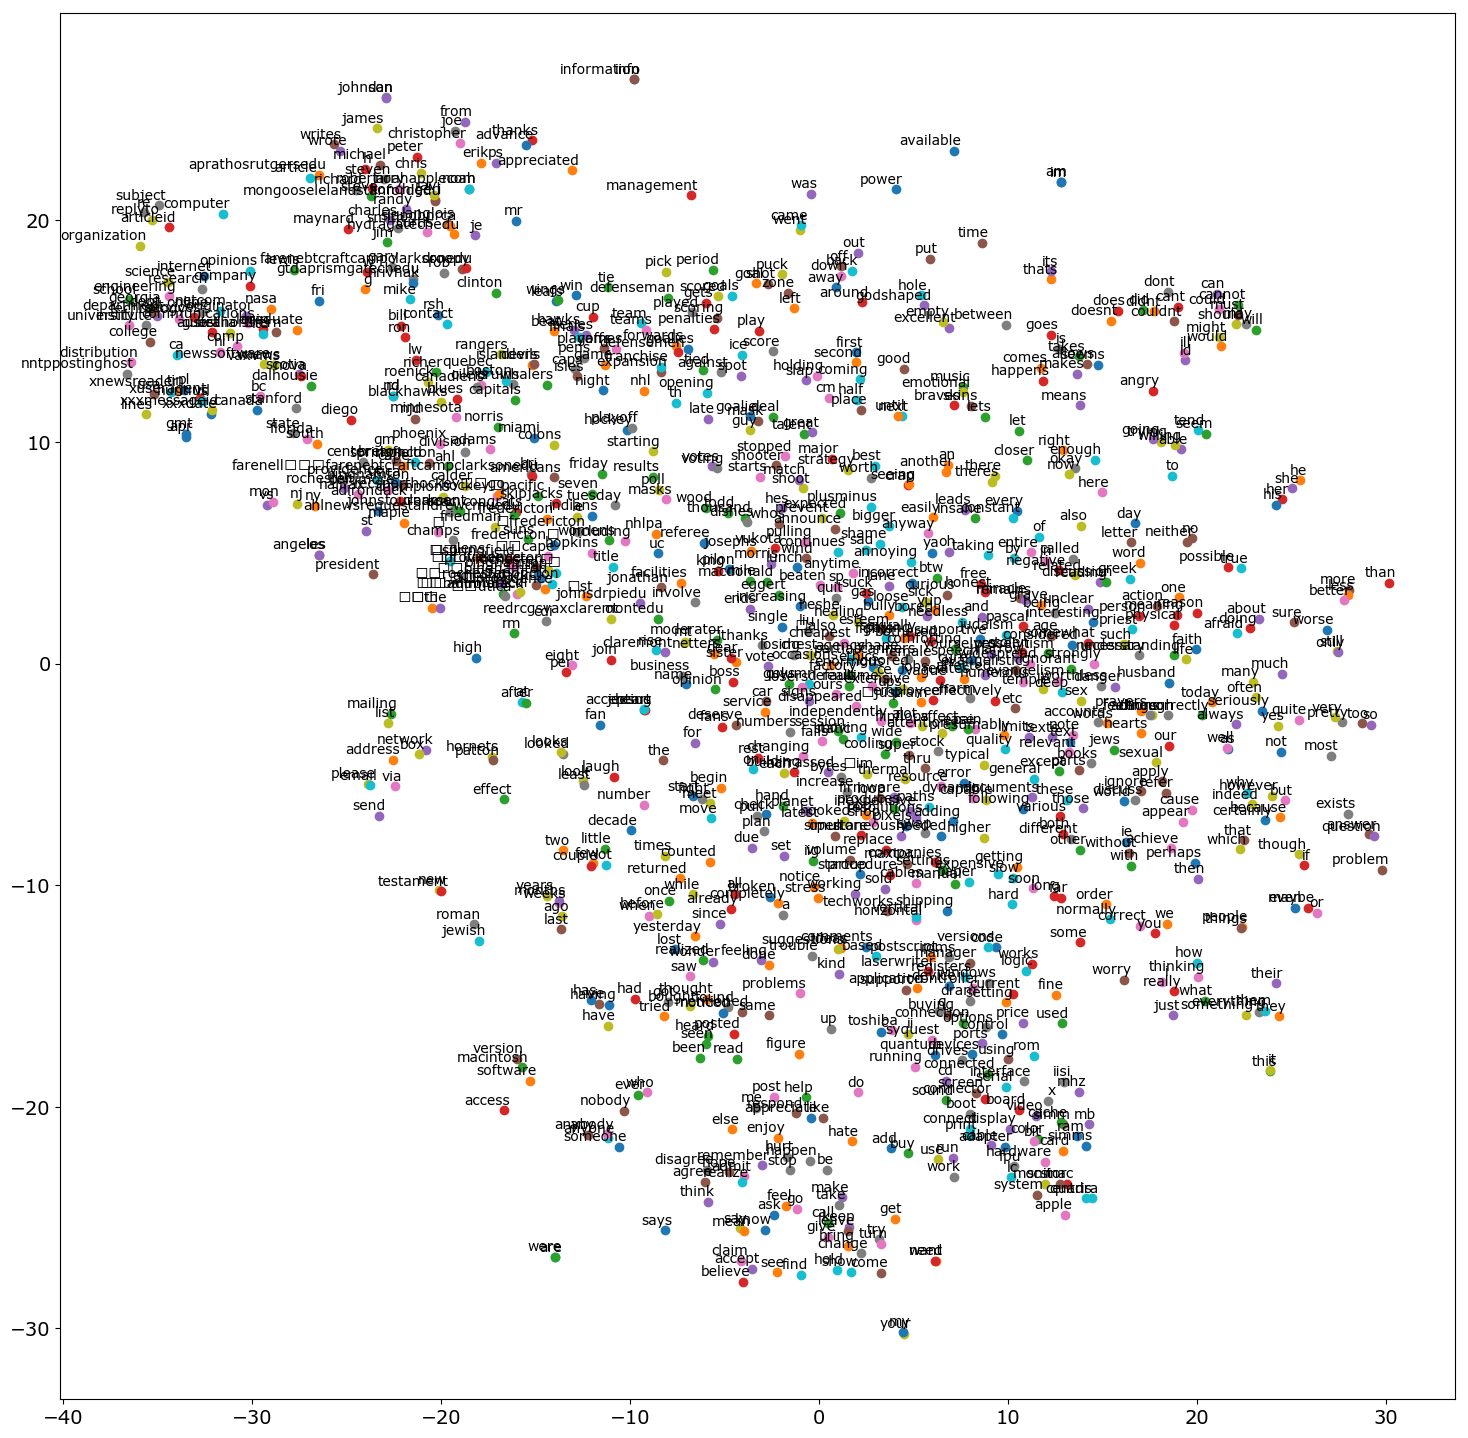

In [29]:
# Рисуем только первые 1000 слов.
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

In [30]:
low_dim_vectors_pca = sklearn.decomposition.PCA(2).fit_transform(embeddings)

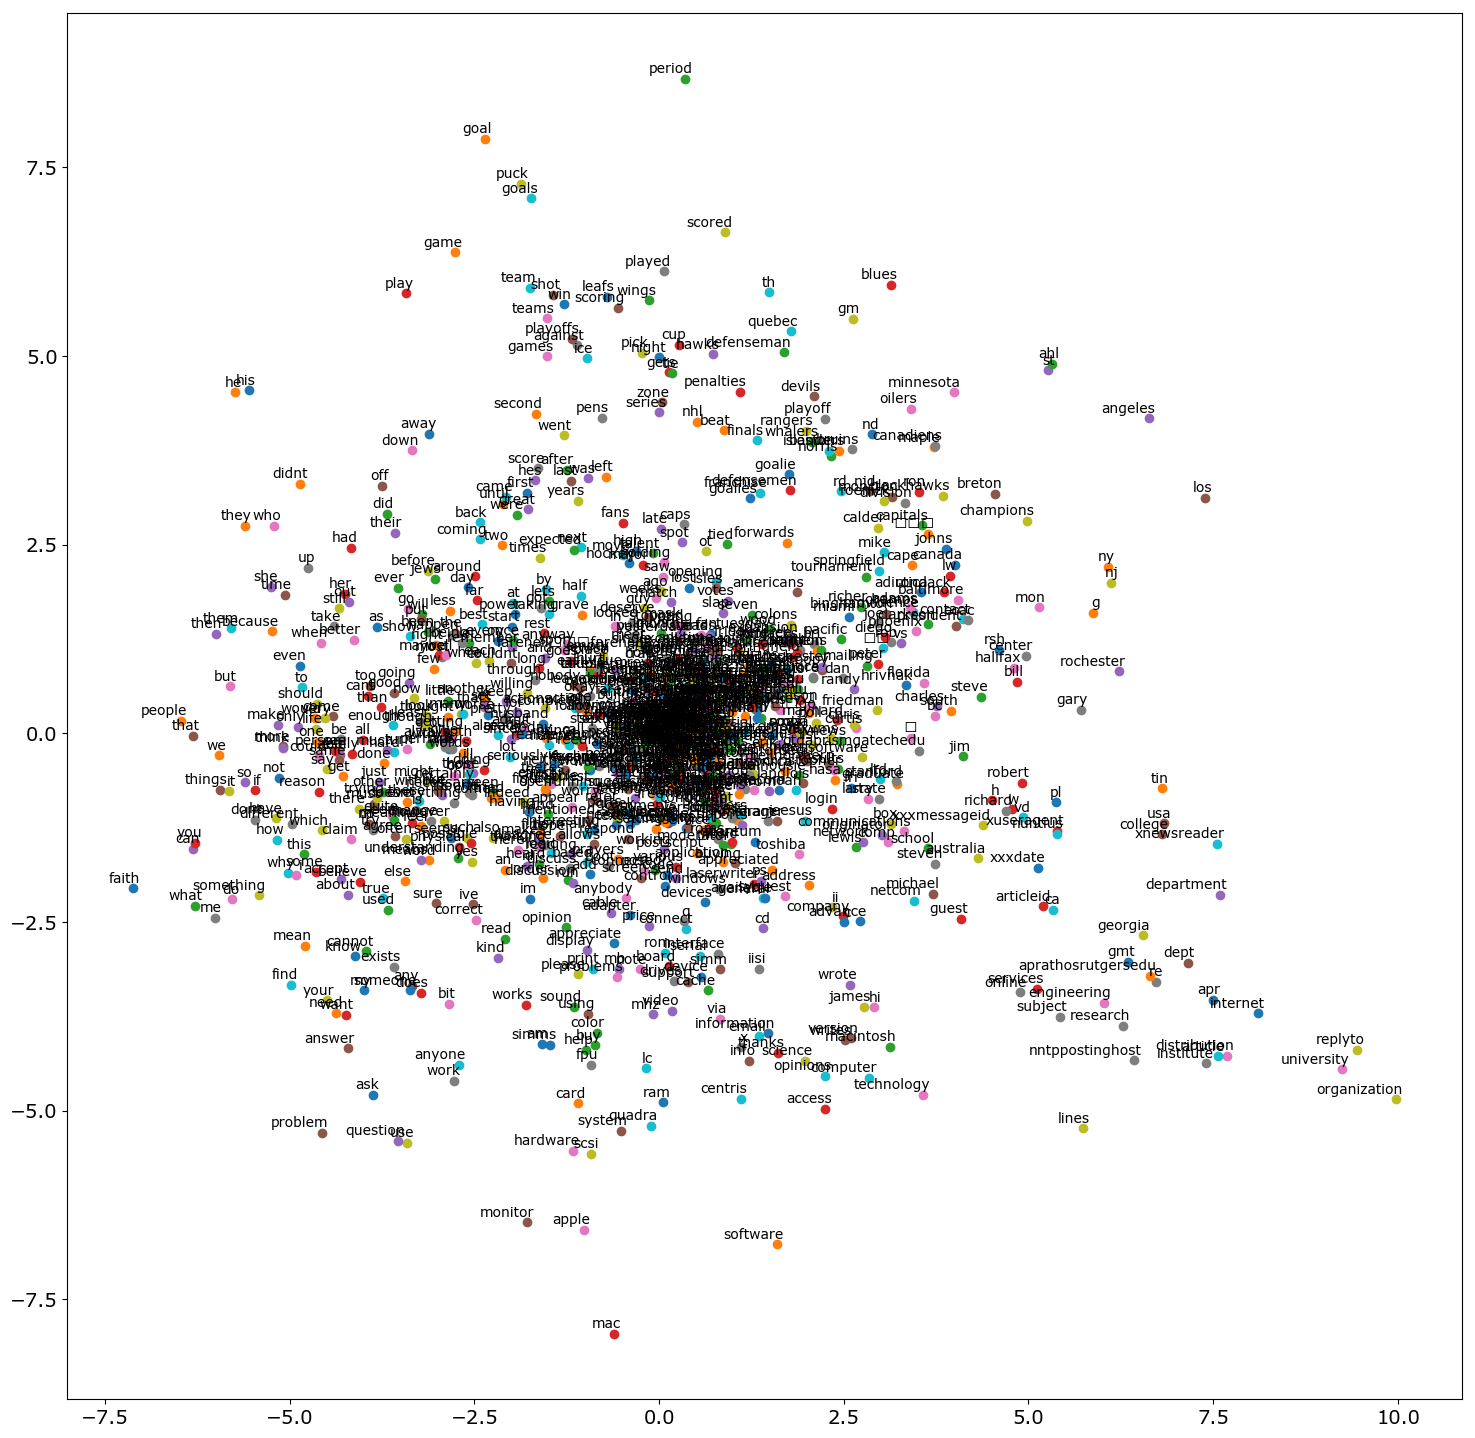

In [31]:
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors_pca, labels_to_draw)


Очевидно, что t-sne работает гораздо лучше. Этот вывод в принципе и бе звизуализации можно было сделать
t-sne более навороченный и соответственно работает дольше

В t-sne отрисовке даже виден кластер из вспомогательных глаголов на верху картинки


### Пункт 3
Проделайте аналогичную отрисовку и сжатие векторов для предобученной модели (для этого скачайте бинарник по этой [ссылке](https://code.google.com/archive/p/word2vec/) (файл GoogleNews-vectors-negative300) по аналогии с тем, как мы работали с русским корпусом. Сравните результаты.

In [33]:
path_to_goognews = 'GoogleNews-vectors-negative300.bin'
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_goognews,
    binary=True
)

2019-04-15 23:39:36,636 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2019-04-15 23:42:19,077 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [37]:
labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model_word2vec[x])
        labels.append(x)
    except KeyError:
        continue

In [38]:
num_words_to_draw = 1000
low_dim_vectors = embeddings_2d(embeddings)

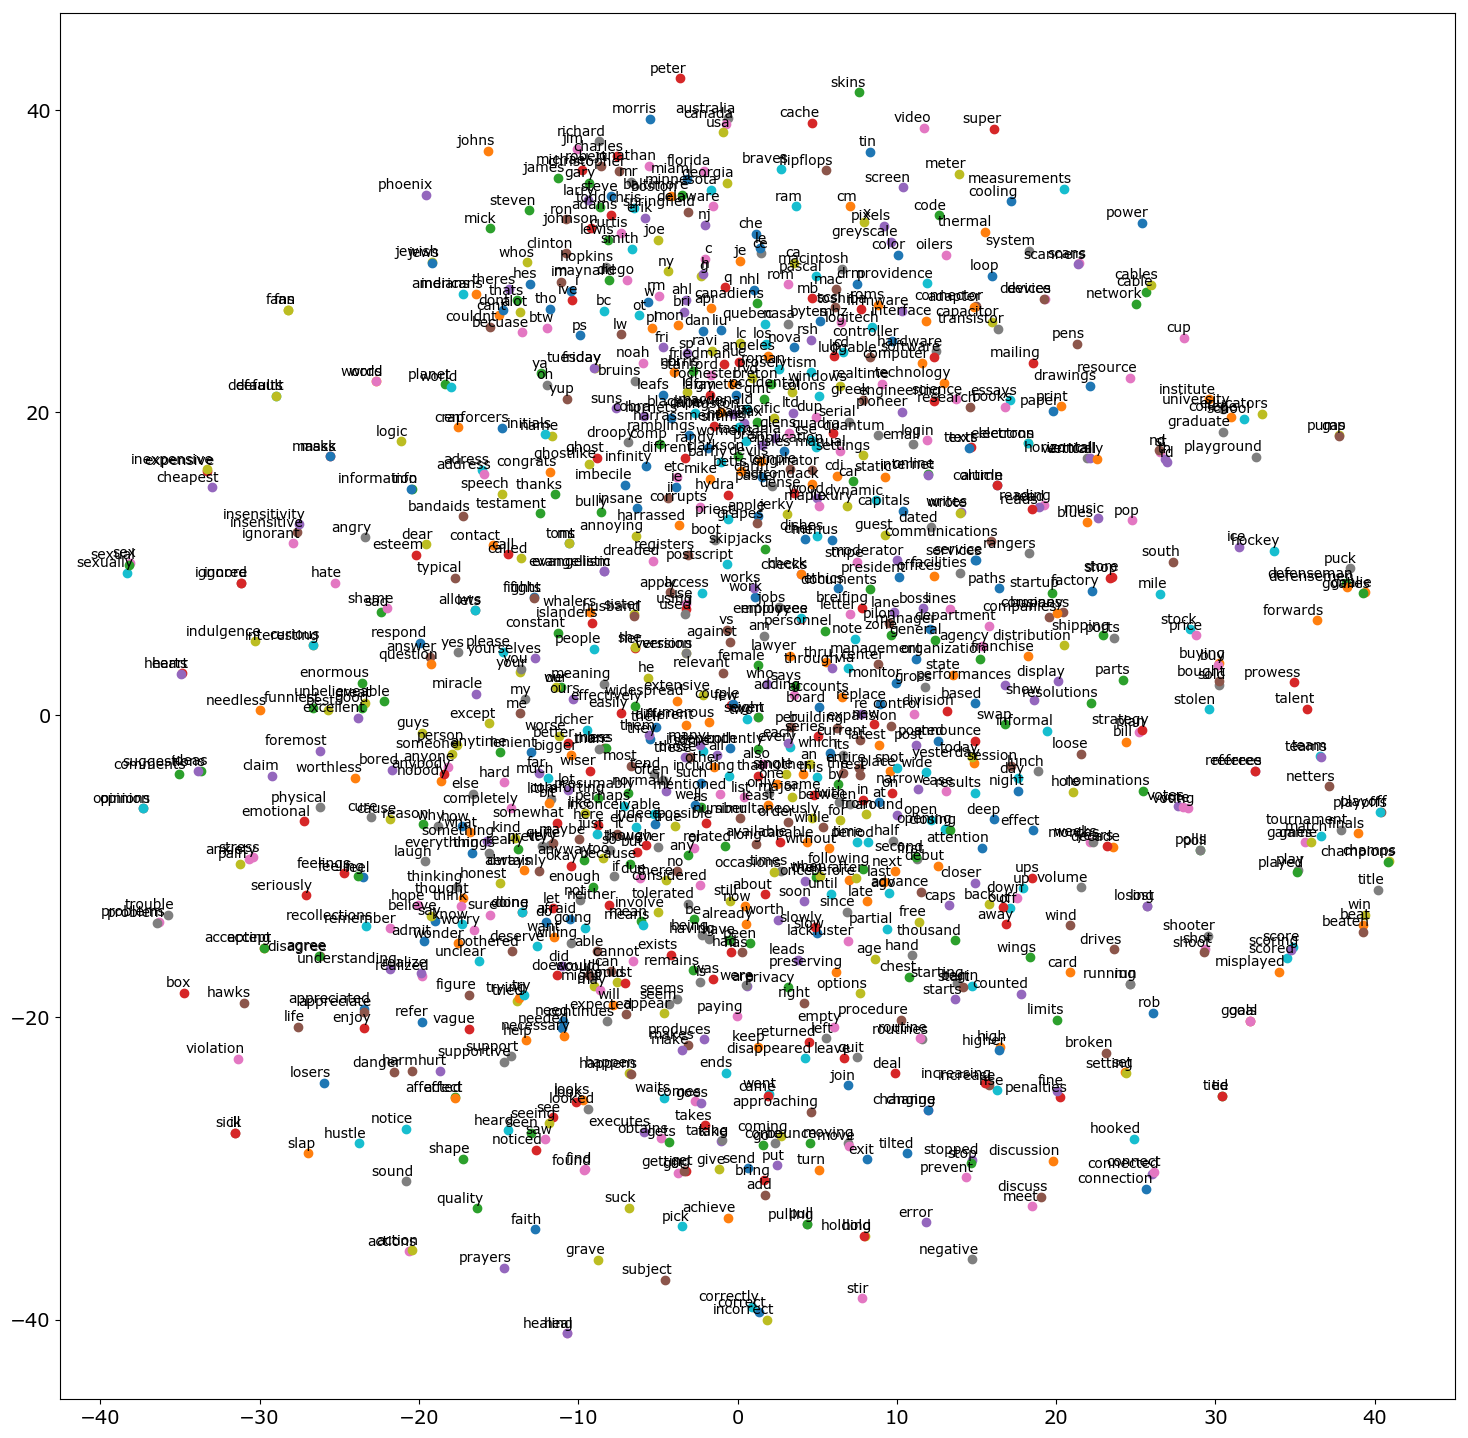

In [39]:
# Рисуем только первые 1000 слов.
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

### Попробуем с помощью нашей модели улучшить качество кластеризации текстов
Если вы не знаете, что такое кластеризация - почитать об этом можно по [ссылке](http://scikit-learn.org/stable/modules/clustering.html).

Если вам все равно кажется, что это сложно, и вы чувствуете себя более уверено в задаче классификации - вместо задачи кластеризации можно рассматривать задачу классификации - тогда вместо функции quality используйте roc-auc из библиотеки scikit-learn, все остальные шаги предобработки и измерения признаков аналогичны.

Измерять качество кластеризации будем следующим образом - измерим количество правильных попаданий категории в кластеры.

In [ ]:
def quality(preds, target):
    permutations = list(itertools.permutations([0, 1, 2]))
    scores = []
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        scores.append(float(sum(mapped_preds != target)) / len(target))
    return 1 - min(scores)

### Пункт 4
Кластеризуйте датасет с заданием признаков с помощью one hot encoding - посмотрите на результат.

In [ ]:
len_one_hot = len(set([item for sublist in data_normalized for item in sublist]))
vocab = {}
for id, word in enumerate(set([item for sublist in data_normalized for item in sublist])):
    encoded = np.zeros(len_one_hot)
    encoded[id] = 1
    vocab[word] = encoded 

### Пункт 5
Далее кластеризуем тексты на векторах, полученных из модели, которую мы сами обучили.

Напишем функцию, которая делает из предложения вектор - усредняет векторы всех слов в этом предложении. Если слова нет в словаре, то вместо вектора этого слова используется нулевой вектор.

In [ ]:
def average_feature_vector(words, model):
    average_feature_vector = < Ваш код >
    return

Применим функцию к нашим данным (уже нормализованным функцией normalize).

In [ ]:
data_normalized_vectors = [average_feature_vector(sent, model)
                           for sent in data_normalized]

Сожмем массив признаков с помощью TSNE до нескольких компонент (попробуйте поварьировать число компонент).

In [ ]:
low_dim_vectors = < Ваш код >

Примените алгоритм кластеризации (например, K-means).

In [ ]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

### Пункт 6

Кластеризуйте тексты на векторах, полученных из предобученной модели. Какой результат получился лучше? Почему?

In [ ]:
<Ваш код>

### Пункт 7

Попробуйте получить аналогичные векторы и провести исследование на них с помощью fastq - [неплохое введение](https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/).

In [ ]:
<Ваш код>

### Пункт 8
С помощью библиотеки pytorch-pretrained-bert попробуйте получить векторы для ваших текстов ([инструкция](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py)) и провести исследование.

In [ ]:
<Ваш код>

### Правила сдачи и критерии оценки:

##### Как и куда сдавать:

К блокноту нужно приложить краткий текстовый отчет в pdf, в котором вы описываете основные моменты: какие шаги выполняли, какое качество получали, а также какие графики рисовали и что это значит.

Оба файла (ipynb блокнот с названием hw07_<имя>_<фамилия>.ipynb и pdf файл-отчет с названанием hw07_<имя>_<фамилия>_report.pdf) нужно загрузить через [гугл-форму](https://forms.gle/JbSQ6toQHQQc3CcF9).

##### Обязательная часть (70% баллов)

1) Пункт 1 - Пункт 7 (по 10% баллов за пункт).

##### Продвинутая часть (30 % баллов)

1) Пункт 8.

2) Любые самые смелые идеи-эксперименты по тому, как можно улучшить качество моделей (пофильтровать какие-то части речи, редкие слова, использовать FastText).

3) Интересные, необычные, просто хорошо сформулированные выводы о вашей работе в отчете.

При проверке отчета будет обращаться внимание на анализ и оригинальность подходов.